In [33]:
import random
import numpy as np
import pandas as pd
import pickle
import csv
import itertools
import os
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns


In [23]:
# Load strain data and parameters
parameter_df = pd.read_csv("Parameters.csv", header=None)
LE_XX = pd.read_csv("LE_XX.csv", header=None)
LE_YY = pd.read_csv("LE_YY.csv", header=None)

# Read in mesh
meshfile = open("V8Template.inp",'r').readlines()
n_lines = len(meshfile)
for i in range(n_lines):
    if meshfile[i][0:5]=="*Node" and '*Node Output' not in meshfile[i] and ('name=SKIN&MUSCLE' in meshfile[i-1]):
        end = 0
        count=0
        node_X_array = []
        node_X_ind = []
        while end<1:
            aux = meshfile[i+count+1].split(',')
            if aux==['CF', ' RF', ' U\n']:
                break
            nodeXi = np.array([float(aux[1]),float(aux[2]),float(aux[3])])
            node_X_array.append(nodeXi)
            node_X_ind.append(int(aux[0]))
            count+=1
            if meshfile[i+count+1][0]=="*":
                end = 1

n_node = count
for i in range(n_lines):
    if meshfile[i][0:5]=="*Elem" and ('type=C3D8H' in meshfile[i]):
        end = 0
        count=0
        elem_array = []
        while end<1:
            aux = meshfile[i+count+1].split(',')
            elemi = np.array([int(aux[1]),int(aux[2]),int(aux[3]),int(aux[4]),int(aux[5]),int(aux[6]),int(aux[7]),int(aux[8])])
            elem_array.append(elemi)
            count+=1
            if meshfile[i+count+1][0]=="*":
                end = 1
        if end==1:
            break

n_elem = count

node_X = np.array(node_X_array)
elements = np.array(elem_array)

In [21]:
# Useful functions
def string_to_list(input_string):
    cleaned_string = input_string.strip('[]')
    numbers_str = cleaned_string.split(',')
    numbers_list = [float(num) for num in numbers_str]
    return numbers_list

def plot_simulation(strain_field, frame):
    tens_place = frame // 10
    ones_place = frame % 10

    fig, ax = plt.subplots()
    ax.set_xlim([-25, 25])
    ax.set_ylim([0, 50])
    ax.set_aspect('equal')
    patches = []
    n_surf_elem = strain_field.shape[0]
    colors = np.zeros((n_surf_elem))
    elemX = np.zeros((n_surf_elem, 2))
    
    # Loop over elements to create patches and assign colors
    for i in range(n_surf_elem):
        n1 = elements[i, 0] - 1
        n2 = elements[i, 1] - 1
        n3 = elements[i, 2] - 1
        n4 = elements[i, 3] - 1
        n1X = np.array([node_X[n1, 0], node_X[n1, 2]])
        n2X = np.array([node_X[n2, 0], node_X[n2, 2]])
        n3X = np.array([node_X[n3, 0], node_X[n3, 2]])
        n4X = np.array([node_X[n4, 0], node_X[n4, 2]])
        elemiX = 0.25 * (n1X + n2X + n3X + n4X)
        elemX[i] = elemiX
        polygon = Polygon([n1X, n2X, n3X, n4X], closed=True)
        patches.append(polygon)
        colors[i] = strain_field[i, frame]
    
    # Set up color normalization based on strain field values
    min_val = np.min(strain_field[:, tens_place * 10 + 9])
    max_val = np.max(strain_field[:, tens_place * 10 + 9])

    norm = Normalize(vmin=min_val, vmax=max_val)

    # Create PatchCollection and add it to the axes
    color_map_name = plt.get_cmap("viridis")
    p = PatchCollection(patches, cmap=color_map_name, norm=norm)
    p.set_array(colors)
    ax.add_collection(p)

    # Remove axis ticks and labels
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_xlabel('')  # Remove x-axis label
    ax.set_ylabel('')  # Remove y-axis label
    
    # Create a divider for the axes to append a horizontal colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)  # Adjust 'size' to control colorbar height
    cbar = fig.colorbar(p, cax=cax, orientation='horizontal')
    cbar.set_label('$LE_{XX}$', fontsize=20)  # Colorbar label font size
    cbar.ax.tick_params(labelsize=20)  # Colorbar tick label font size
    plt.show()

In [27]:
# Noise data
LE_XX_noise = pd.read_csv("../noisy_inverse/LE_XX_10s.csv", header=None)

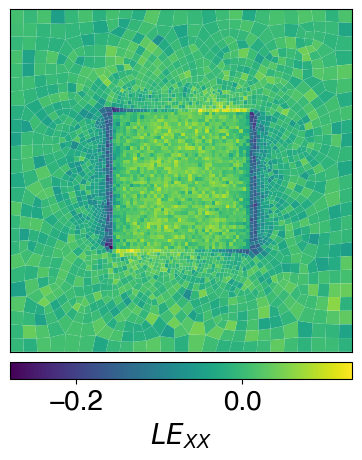

In [28]:
# Simulation choice
# strain_field = np.array(LE_XX)
strain_field = np.array(LE_XX_noise)
plot_simulation(strain_field, 16799) # Anything from 0 to 16799

In [30]:
# Load in PCA files
LE_XX_train_targets = pd.read_csv("LE_XX_comps_train.csv", header=None, index_col=0)
LE_XX_test_targets = pd.read_csv("LE_XX_comps_test.csv", header=None, index_col=0)
LE_YY_train_targets = pd.read_csv("LE_YY_comps_train.csv", header=None, index_col=0)
LE_YY_test_targets = pd.read_csv("LE_YY_comps_test.csv", header=None, index_col=0)
train_labels = pd.read_csv("param_train.csv", header=None, index_col=0)
test_labels = pd.read_csv("param_test.csv", header=None, index_col=0)

In [34]:
random.seed(201)

# Define the range and the sample size
range_end = 120
sample_size = 100

# Generate the sample
skin_train_samples = random.sample(range(range_end), sample_size)
skin_train_samples = sorted(skin_train_samples)

# Lets get the other skin parameters indicies
skin_test_samples = [i for i in range(range_end) if i not in skin_train_samples]
skin_test_samples = sorted(skin_test_samples)

experimentwise_parameters = []

for i in range(int(parameter_df.shape[1] / 10)):
    experimentwise_parameters.append(parameter_df.T[i * 10: (i + 1) * 10])

sorted_parameters = []
for i in range(120):
    sorted_parameters.append(experimentwise_parameters[i::120])

param_train_df = [sorted_parameters[train_ind] for train_ind in skin_train_samples]
param_test_df = [sorted_parameters[test_ind] for test_ind in skin_test_samples]

train_indicies = []
test_indicies = []
for skin_set in param_train_df:
    internal = list(pd.concat(skin_set).index)
    train_indicies += internal

for skin_set in param_test_df:
    internal = list(pd.concat(skin_set).index)
    test_indicies += internal

param_train_df = parameter_df.T.loc[train_indicies]
param_test_df = parameter_df.T.loc[test_indicies]

LE_XX_train_df = LE_XX.T.loc[train_indicies]
LE_XX_test_df = LE_XX.T.loc[test_indicies]

LE_YY_train_df = LE_YY.T.loc[train_indicies]
LE_YY_test_df = LE_YY.T.loc[test_indicies]

LE_XX_scalar = preprocessing.StandardScaler()
LE_YY_scalar = preprocessing.StandardScaler()

LE_XX_scaled = LE_XX_scalar.fit_transform(LE_XX_train_df)
LE_YY_scaled = LE_YY_scalar.fit_transform(LE_YY_train_df)
LE_XX_test_scaled = LE_XX_scalar.transform(LE_XX_test_df)
LE_YY_test_scaled = LE_YY_scalar.transform(LE_YY_test_df)

pca_LE_XX = PCA(n_components=8, svd_solver="randomized") # n_components=8
pca_LE_YY = PCA(n_components=8, svd_solver="randomized") # n_components=8
pca_LE_XX.fit(LE_XX_scaled)
pca_LE_YY.fit(LE_YY_scaled)

LE_XX_comps_train = pca_LE_XX.transform(LE_XX_scaled)
LE_YY_comps_train = pca_LE_YY.transform(LE_YY_scaled)
LE_XX_comps_test = pca_LE_XX.transform(LE_XX_test_scaled)
LE_YY_comps_test = pca_LE_YY.transform(LE_YY_test_scaled)

0.9942614448538135
0.9940281331948801


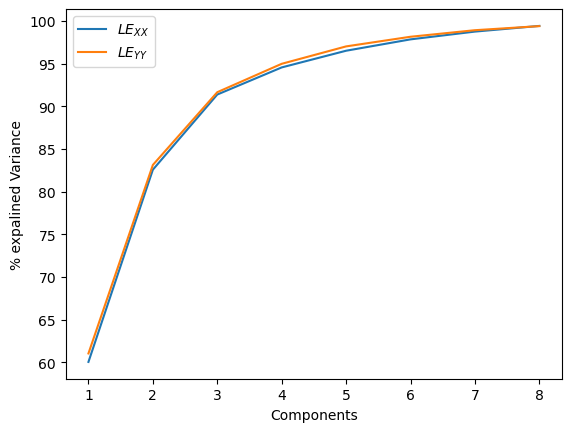

In [35]:
# PCA explained variance

x = range(0,8)
LE_XX_cvr = np.cumsum(pca_LE_XX.explained_variance_ratio_)
LE_YY_cvr = np.cumsum(pca_LE_YY.explained_variance_ratio_)

print(LE_XX_cvr[7])
print(LE_YY_cvr[7])
plt.plot(np.array(x)+1, LE_XX_cvr[x] * 100, label="$LE_{XX}$")
plt.plot(np.array(x)+1, LE_YY_cvr[x] * 100, label="$LE_{YY}$")
plt.ylabel("% expalined Variance")
plt.xlabel("Components")
plt.ylabel("% expalined Variance")
plt.legend()

In [36]:
# PCA Plotting
def plot_component(strain, comp, save_path):
    fig, ax = plt.subplots()
    
    ax.set_xlim([-25, 25])
    ax.set_ylim([0, 50])
    ax.set_aspect('equal')
    
    # Remove x and y ticks, but keep the axis outline (black outline)
    ax.set_xticks([])  # Hide x-axis ticks
    ax.set_yticks([])  # Hide y-axis ticks

    patches = []
    viridis = matplotlib.cm.get_cmap('viridis', 50)
    n_surf_elem = strain.shape[1]
    colors = np.zeros((n_surf_elem))
    elemX = np.zeros((n_surf_elem, 2))

    for i in range(n_surf_elem):
        n1 = elements[i, 0] - 1
        n2 = elements[i, 1] - 1
        n3 = elements[i, 2] - 1
        n4 = elements[i, 3] - 1
        
        n1X = np.array([node_X[n1, 0], node_X[n1, 2]])
        n2X = np.array([node_X[n2, 0], node_X[n2, 2]])
        n3X = np.array([node_X[n3, 0], node_X[n3, 2]])
        n4X = np.array([node_X[n4, 0], node_X[n4, 2]])
        elemiX = 0.25 * (n1X + n2X + n3X + n4X)
        elemX[i] = elemiX
        
        polygon = Polygon([n1X, n2X, n3X, n4X], closed=True)
        patches.append(polygon)
        colors[i] = strain[comp, i]

    color_map_name = plt.colormaps["viridis"]
    p = PatchCollection(patches, cmap=color_map_name)
    p.set_array(colors)
    ax.add_collection(p)

    # Adjust plot margins
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

    # Save the figure with a transparent background
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, transparent=True)

    plt.close()  # Close the plot after saving to free up memory

# Loop through all components and save each plot
def save_all_components(strain):
    num_components = strain.shape[0]  # Assuming strain has components in the first dimension
    for comp in range(num_components):
        file_name = f'component_{comp}_plot.png'
        plot_component(strain, comp, file_name)
        print(f'Saved: {file_name}')

# Usage example
components = pca_LE_XX.components_
# save_all_components(components)


/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_75286/2056929699.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = matplotlib.cm.get_cmap('viridis', 50)


Saved: component_0_plot.png
Saved: component_1_plot.png
Saved: component_2_plot.png
Saved: component_3_plot.png
Saved: component_4_plot.png
Saved: component_5_plot.png
Saved: component_6_plot.png
Saved: component_7_plot.png


<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\k'
<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\k'
/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_9989/3364088878.py:56: SyntaxWarning: invalid escape sequence '\m'
  var_names = ["$\mu$ (MPa)", "$k_1$ (MPa)", "$k_2$", "$\kappa$", "$\\theta$"]
/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_9989/3364088878.py:56: SyntaxWarning: invalid escape sequence '\k'
  var_names = ["$\mu$ (MPa)", "$k_1$ (MPa)", "$k_2$", "$\kappa$", "$\\theta$"]


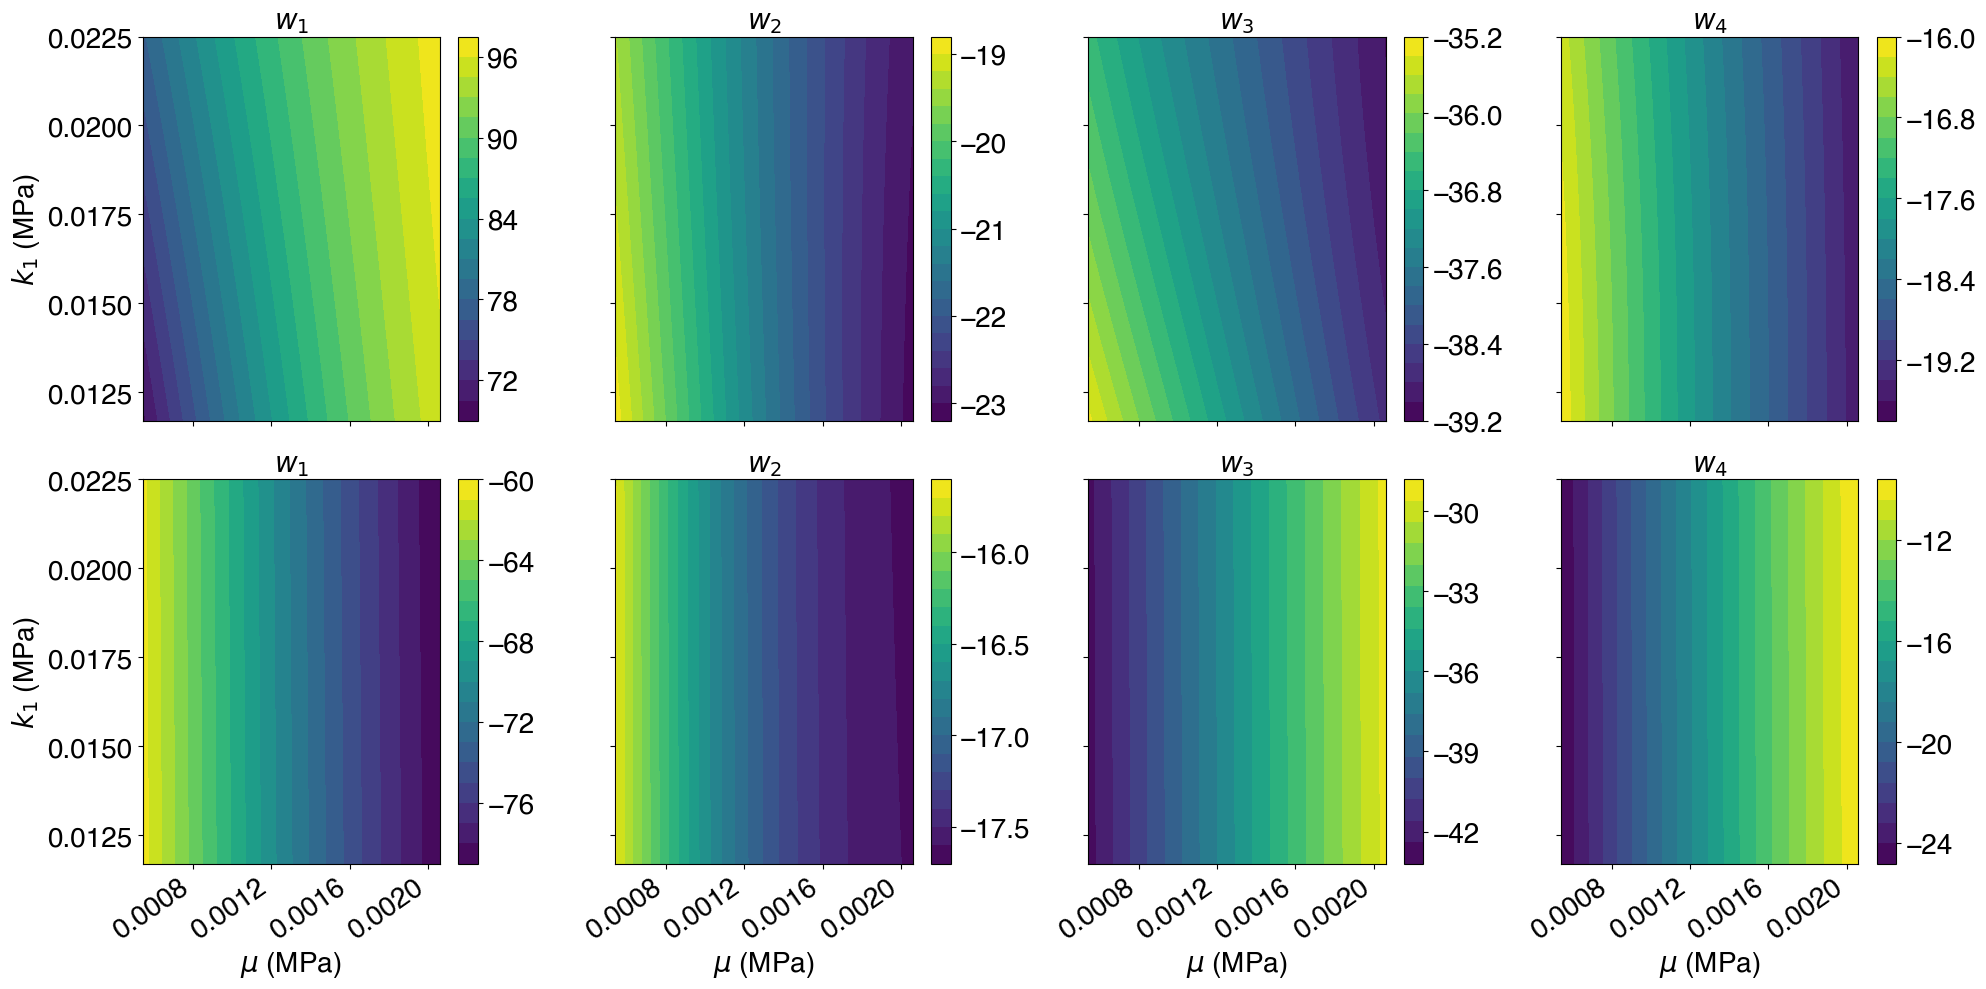

In [40]:
# Figure 10 plot
params = []

# Read in data
with open("../data_generation/skin_parameters.csv", 'r') as param_file:
    reader = csv.reader(param_file, delimiter=',') 
    for row in reader:
        params.append(row) # Read each row and add it to params
        
# Get only the in vivo conditions and format so that each row is the range
in_vivo = np.array(params[5:9]).T

# Get the max and min of each param
max_params = []
min_params = []
for element in in_vivo:
    max_params.append(max(map(float,element))) # Get the max element from each set
    min_params.append(min(map(float,element))) # Get the min element from each set

# Add the angle variation into the max and min sets
max_params.append(90)
min_params.append(0)


mean_params = np.array([1.3015e-3, 1.71e-2, 11.815, 0.285, 45, 0.05, 0.05]) # mu, k1, k2, kappa, theta

# Import GP Model's of both the noisy and noiseless case
with open('XX_GP.pkl', 'rb') as f:
    gpr_xx = pickle.load(f)

with open('YY_GP.pkl', 'rb') as f:
    gpr_yy = pickle.load(f)

with open('../noisy_inverse/XX_GP_s5.pkl', 'rb') as f:
    s1_gpr_xx = pickle.load(f)

with open('../noisy_inverse/YY_GP_s5.pkl', 'rb') as f:
    s1_gpr_yy = pickle.load(f)

# For plots, hold all parameters constant except the two that are changing
n_samples = 100
mu_samples = np.linspace(min_params[0], max_params[0], n_samples)
k1_samples = np.linspace(min_params[1], max_params[1], n_samples)
k2_samples = np.linspace(min_params[2], max_params[2], n_samples)
kappa_samples = np.linspace(min_params[3], max_params[3], n_samples)
theta_samples = np.linspace(min_params[4], max_params[4], n_samples)
a1_samples = np.linspace(-0.05, 0.05, n_samples)
a2_samples = np.linspace(-0.05, 0.05, n_samples)

# Adjustable parameters
font_size = 20
tick_font_size = 20
plt.rcParams.update({'font.family': 'Helvetica'})

# Define variables
var_names = ["$\mu$ (MPa)", "$k_1$ (MPa)", "$k_2$", "$\kappa$", "$\\theta$"]

# Create sample points for mu and k1 (assuming these are your var1 and var2)
n_samples = 100
var1 = np.linspace(min_params[0], max_params[0], n_samples)  # mu
var2 = np.linspace(min_params[1], max_params[1], n_samples)  # k1
ind1 = 0
ind2 = 1

# Use mean values for other parameters
ind_array = [x for x in range(7) if (x != ind1) and (x != ind2)]
other_params = [mean_params[i] for i in ind_array]

# Generate all combinations of points using itertools.product
combinations = list(itertools.product(var1, var2))

# Prepare input arrays
inputs_12 = []
for pair in combinations:
    constructed_input = np.zeros(7)
    constructed_input[[ind1, ind2]] = pair
    constructed_input[ind_array] = other_params
    inputs_12.append(np.array(constructed_input))

inputs_12 = np.array(inputs_12)

# Get predictions for both noiseless and noisy data
xx_values = gpr_xx.predict(inputs_12)
s1_xx_values = s1_gpr_xx.predict(inputs_12)

# Reshape values to fit the grid format
xx_values = xx_values.reshape(len(var1), len(var2), 8)
s1_xx_values = s1_xx_values.reshape(len(var1), len(var2), 8)

# Create a 2x4 subplot figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# Iterate through each of the 8 plots
for i in range(8):
    # Extract the data for the i-th variable
    if i < 4:  # First row: noiseless w1-w4
        xx_val = xx_values[:, :, i]
    else:  # Second row: noisy w1-w4
        xx_val = s1_xx_values[:, :, i-4]
    
    # Find the corresponding subplot in the grid
    ax = axes[i // 4, i % 4]
    
    # Create the contour plot
    contour = ax.contourf(var1, var2, xx_val.T, levels=20, cmap='viridis')
    
    # Add a colorbar for each subplot
    cbar = fig.colorbar(contour, ax=ax)
    cbar.ax.tick_params(labelsize=tick_font_size)
    
    # Set axis labels and title
    if i < 4:
        ax.set_title(f'$w_{i+1}$', fontsize=font_size)
    else:
        ax.set_title(f'$w_{i-3}$', fontsize=font_size)
    
    ax.set_xlabel(var_names[ind1], fontsize=font_size)
    ax.set_ylabel(var_names[ind2], fontsize=font_size)
    
    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
    plt.setp(ax.get_xticklabels(), rotation=35, ha='right')
    
    # Reduce number of ticks
    ax.xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.yaxis.set_major_locator(plt.MaxNLocator(5))
    cbar.locator = plt.MaxNLocator(5)
    cbar.update_ticks()
    
    # Remove ticks and labels for non-edge plots
    if i % 4 != 0:  # Not first column
        ax.set_ylabel('')
        ax.set_yticklabels([])
    if i < 4:  # Not bottom row
        ax.set_xlabel('')
        ax.set_xticklabels([])

# Adjust layout
plt.tight_layout()
plt.show()

In [16]:
s1_gpr_xx.kernel_.get_params()

{'k1': 43.6**2,
 'k2': RBF(length_scale=[0.00528, 6.46, 2.83e+04, 7.3, 57.7, 0.104, 0.101]),
 'k1__constant_value': np.float64(1902.5697649923475),
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': array([5.27864381e-03, 6.46313660e+00, 2.83017096e+04, 7.29779748e+00,
        5.77246097e+01, 1.04354993e-01, 1.01415896e-01]),
 'k2__length_scale_bounds': (1e-05, 100000.0)}

<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\k'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\k'
<>:55: SyntaxWarning: invalid escape sequence '\d'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\k'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\k'
<>:55: SyntaxWarning: invalid escape sequence '\d'
/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_9989/347713444.py:38: SyntaxWarning: invalid escape sequence '\m'
  "mu": "$\mu$ (MPa)",
/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_9989/347713444.py:41: SyntaxWarning: invalid escape sequence '\k'
  "kappa": "$\kappa$ (-)",
/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_9989/347713444.py:42: SyntaxW

1     0.000780
2     0.021358
3    13.686609
4     0.279915
5    13.937620
6     0.050000
7     0.050000
Name: 14879, dtype: float64


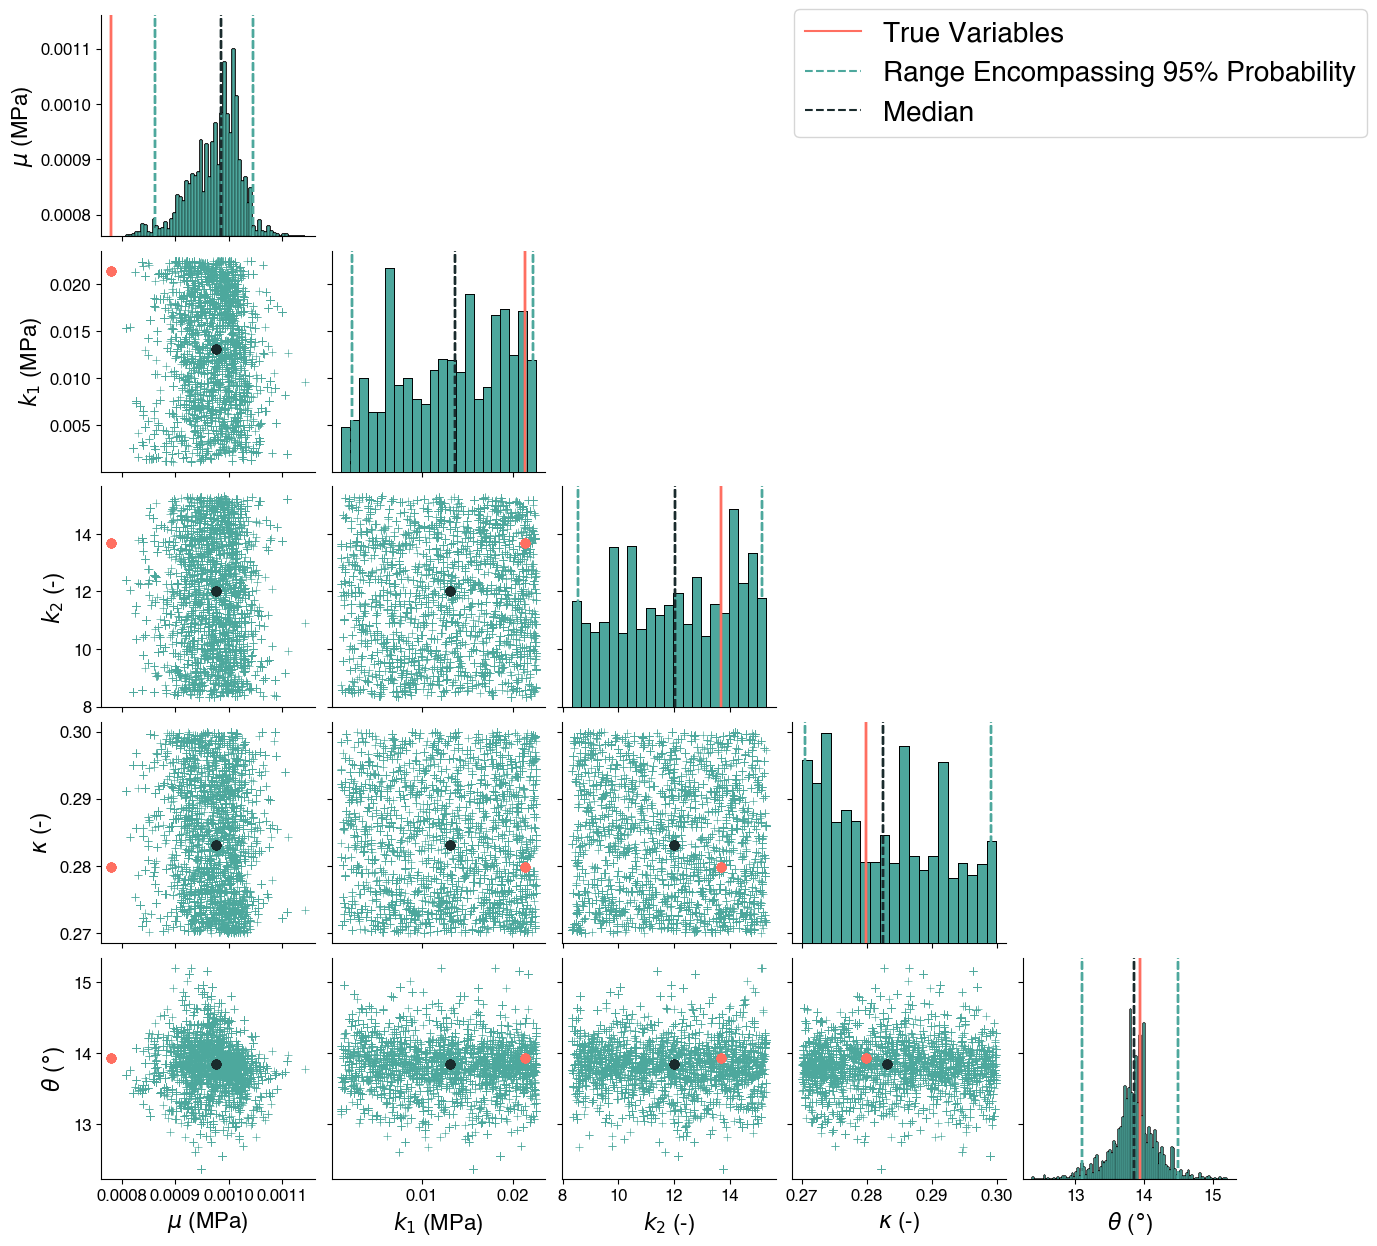

In [38]:
# MCMC Plots for single observations
skin_set = 5
noise_data = "s10"
expansion_type = "max"
_expansion_type = "Max"

plot_data = pd.read_csv(f"../noisy_inverse/mcmc_samples/MCMC{skin_set}_{noise_data}_Comp_{_expansion_type}.csv", index_col=0)
labels = pd.read_csv(f"../noisy_inverse/{noise_data}_partitioned_data/{noise_data}_{expansion_type}_expansion_labels.csv", index_col=0, header=None)

label = labels.iloc[skin_set, :]

variables = plot_data[["mu", "k1", "k2", "kappa", "theta"]]
print(label)

# Set Helvetica as the font for all text
plt.rcParams['font.family'] = 'Helvetica'

# Font size control
title_fontsize = 16
label_fontsize = 16  # Set for x and y labels
tick_fontsize = 12
legend_fontsize = 20  # Adjust this for larger legend font size

# Set custom colors
scatter_color = '#4DA89D'           # Custom color for scatter points
true_point_color = '#FF6F61'        # Custom color for "True Variables" points
mean_point_color = '#1A2B2D'        # Custom color for the mean points
percentile_color = '#4DA89D'        # Custom color for 2.5th and 97.5th percentile lines
median_line_color = '#1A2B2D'       # Custom color for the median line
hist_color = '#4DA89D'              # Custom color for the diagonal histograms

# Define the DataFrame with updated column labels for LaTeX-style formatting
variables_df = pd.DataFrame(variables, columns=[
    "mu", "k1", "k2", "kappa", "theta"
])

variables_df = variables_df.rename(columns={
    "mu": "$\mu$ (MPa)", 
    "k1": "$k_1$ (MPa)", 
    "k2": "$k_2$ (-)", 
    "kappa": "$\kappa$ (-)", 
    "theta": "$\\theta$ ($\degree$)"
})

# Create the pair plot
pair_plot = sns.pairplot(
    variables_df,
    kind='scatter',
    markers="+",
    plot_kws={'color': scatter_color}
)

# Update true variables dictionary with LaTeX-style labels as keys
true_variables = dict(zip([
    "$\mu$ (MPa)", "$k_1$ (MPa)", "$k_2$ (-)", "$\kappa$ (-)", "$\\theta$ ($\degree$)"
], label[0:5]))

# Function to plot specific points on off-diagonal plots
def plot_specific_point(x, y, **kwargs):
    plt.plot(true_variables[x.name], true_variables[y.name], 'o', color=true_point_color, label='True Variables')
    plt.plot(np.mean(x), np.mean(y), 'o', color=mean_point_color, label='Mean')  # Mean point with custom color

# Function to plot the diagonal with histogram and vertical lines for percentiles and median
def plot_vertical_line(x, **kwargs):
    lower_percentile = np.percentile(x, 2.5)
    upper_percentile = np.percentile(x, 97.5)
    
    median = np.median(x)

    sns.histplot(x, color=hist_color, kde=False, ax=plt.gca())  # Diagonal histogram with custom color
    plt.axvline(true_variables[x.name], color=true_point_color, linestyle='-', label='True Variables')
    plt.axvline(lower_percentile, color=percentile_color, linestyle='--')
    plt.axvline(upper_percentile, color=percentile_color, linestyle='--', label='Range Encompassing 95% Probability')
    plt.axvline(median, color=median_line_color, linestyle='--', label='Median')

# Apply the plotting functions to the lower triangle only
for i, j in zip(*np.tril_indices_from(pair_plot.axes, -1)):
    pair_plot.axes[i, j].plot()
    pair_plot.map_offdiag(plot_specific_point)
    pair_plot.map_diag(plot_vertical_line)

# Hide the upper triangle by setting the axis off
for i, j in zip(*np.triu_indices_from(pair_plot.axes, 1)):
    pair_plot.axes[i, j].set_visible(False)

# Adjust the labels font size
for ax in pair_plot.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize=label_fontsize)
    ax.set_ylabel(ax.get_ylabel(), fontsize=label_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# Adjusting the legend position outside the plot area and increasing font size
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
pair_plot.fig.legend(
    by_label.values(),
    by_label.keys(),
    loc='upper right',
    bbox_to_anchor=(1.1, 1),
    fontsize=legend_fontsize  # Larger font size for the legend
)

# Display the plot
plt.show()


<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\k'
<>:52: SyntaxWarning: invalid escape sequence '\d'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\k'
<>:52: SyntaxWarning: invalid escape sequence '\d'
/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_9989/3774111991.py:52: SyntaxWarning: invalid escape sequence '\m'
  param_names = ["$\mu (MPa)$", "$k_1 (MPa)$", "$k_2$ (-)", "$\kappa (-)$", "$\\theta (\degree)$"]
/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_9989/3774111991.py:52: SyntaxWarning: invalid escape sequence '\k'
  param_names = ["$\mu (MPa)$", "$k_1 (MPa)$", "$k_2$ (-)", "$\kappa (-)$", "$\\theta (\degree)$"]
/var/folders/lt/36qhdtd13yvcmvls77tr_rjr0000gp/T/ipykernel_9989/3774111991.py:52: SyntaxWarning: invalid escape sequence '\d'
  param_names = ["$\mu (MPa)$", "$k_1 (MPa)$", "$k_2$ (-)", "$\kappa (-)$", "$\\theta (\degree)$"]


File ../noisy_inverse/mcmc_samples/MCMC4_s10_Comp_Max.csv does not exist. Skipping...


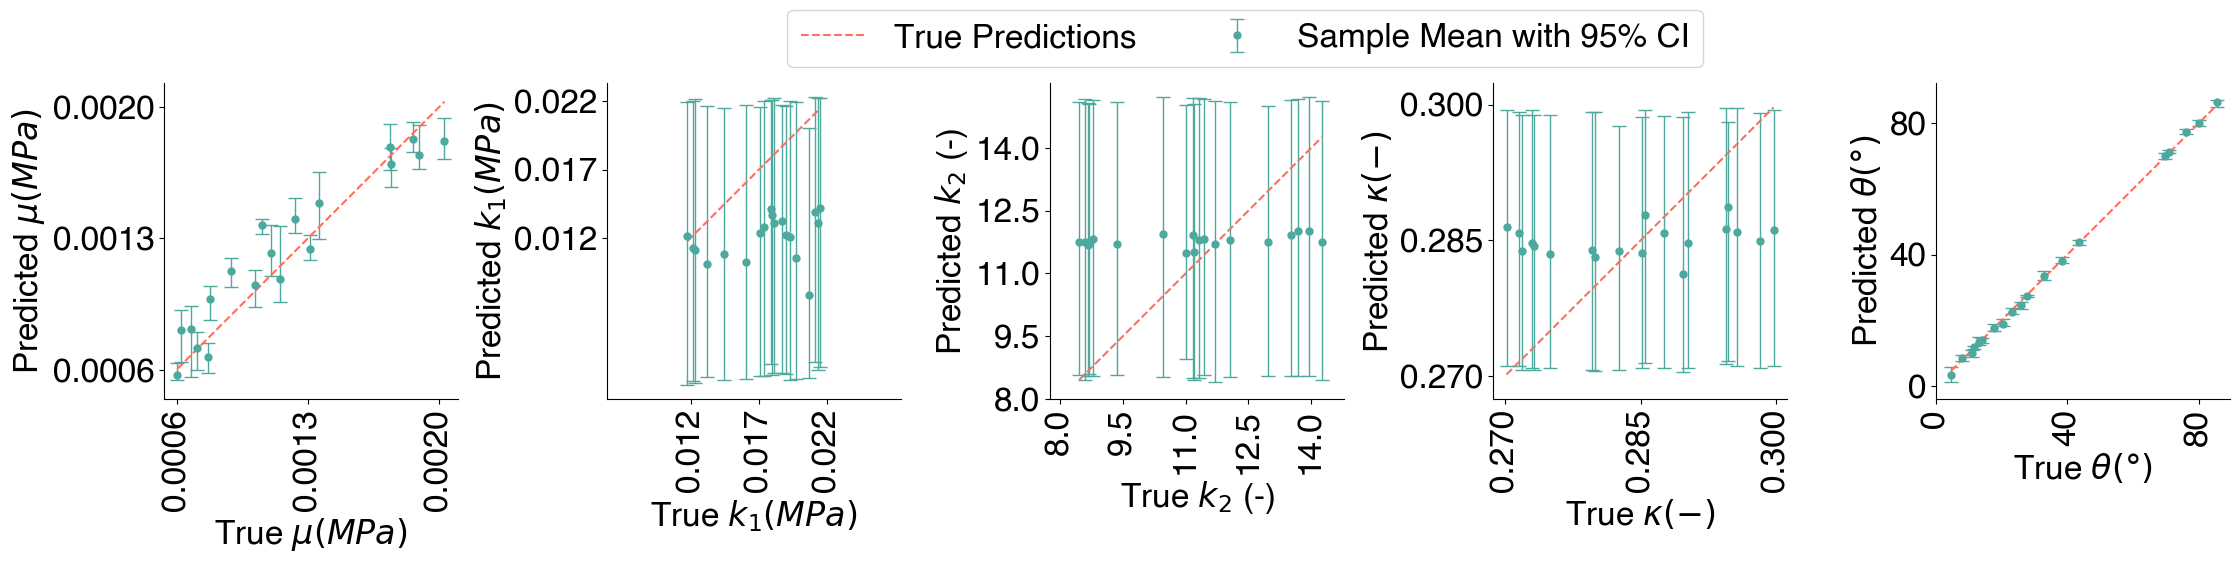

In [39]:
noise_data = "s10"
expansion_type = "max"
_expansion_type = "Max"

# Function to calculate the mode using KDE
def calculate_mode(data):
    kde = gaussian_kde(data)
    x = np.linspace(min(data), max(data), 1000)
    mode = x[np.argmax(kde(x))]
    return mode

# Load the true parameters
params = pd.read_csv(f"../noisy_inverse/{noise_data}_partitioned_data/{noise_data}_{expansion_type}_expansion_labels.csv", index_col=0, header=None)

# Initialize stats arrays
mean_array = []
ci_lower_array = []
ci_upper_array = []
true_values_array = []

for i in range(20):
    file_path = f"../noisy_inverse/mcmc_samples/MCMC{i}_{noise_data}_Comp_{_expansion_type}.csv"
    if not os.path.exists(file_path):
        print(f"File {file_path} does not exist. Skipping...")
        continue

    mcmc_df = pd.read_csv(file_path, index_col=0)[["mu", "k1", "k2", "kappa", "theta"]]
    true_values = params.iloc[i].values[0:5]  # Align with the corresponding file index

    # Calculating mean
    sample_mean = mcmc_df.mean()

    # Calculating confidence intervals using percentiles
    ci_lower = mcmc_df.quantile(0.025)  # 2.5th percentile for the lower bound
    ci_upper = mcmc_df.quantile(0.975)  # 97.5th percentile for the upper bound

    # Save results
    mean_array.append(sample_mean.values)
    ci_lower_array.append(ci_lower.values)
    ci_upper_array.append(ci_upper.values)
    true_values_array.append(true_values)  # Store true values

# Convert lists to numpy arrays for easier plotting
mean_array = np.array(mean_array)
ci_lower_array = np.array(ci_lower_array)
ci_upper_array = np.array(ci_upper_array)
true_values_array = np.array(true_values_array)

# Plotting
fig, axs = plt.subplots(1, 5, figsize=(25, 5))  # Adjust figsize to suit a single row

param_names = ["$\mu (MPa)$", "$k_1 (MPa)$", "$k_2$ (-)", "$\kappa (-)$", "$\\theta (\degree)$"]
axis_font_size = 24
legend_font_size = 24 # Adjustable font size for the legend
tick_size = 24 # Font size for tick labels

min_tick = [0.0006, 0.012, 8, 0.27, 0]
max_tick = [0.002, 0.022, 14, 0.3, 80]

for i in range(5):
    true_values = true_values_array[:, i]
    predicted_means = mean_array[:, i]
    lower_errors = predicted_means - ci_lower_array[:, i]
    upper_errors = ci_upper_array[:, i] - predicted_means

    # Plot mean with error bars in a single row, customize color (e.g., blue for markers, black for error bars)
    axs[i].errorbar(true_values, predicted_means, yerr=[lower_errors, upper_errors], fmt='o', 
                    color='#4DA89D', ecolor='#4DA89D', label='Sample Mean with 95% CI', 
                    markersize=5, capsize=5, elinewidth=1)

    # Generate a line based on the range of true_values
    x_line = np.linspace(min(true_values), max(true_values), 10)

    # Plot a black dashed line with the color specified
    axs[i].plot(x_line, x_line, color="#FF6F61", linestyle='--', label='True Predictions')

    axs[i].set_xlabel(f"True {param_names[i]}", fontsize=axis_font_size)
    axs[i].set_ylabel(f"Predicted {param_names[i]}", fontsize=axis_font_size)
    axs[i].set_aspect('equal', adjustable='datalim')  # Set aspect ratio to be equal

    axs[i].tick_params(axis='x', labelsize=tick_size, rotation=90)
    axs[i].tick_params(axis='y', labelsize=tick_size)

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    
    # Set specific x and y ticks for each subplot
    axs[i].set_xticks(np.linspace(min_tick[i], max_tick[i], 3 if i != 2 else 5))
    axs[i].set_yticks(np.linspace(min_tick[i], max_tick[i], 3 if i != 2 else 5))

# Create a single legend for the whole figure, positioned above the plots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, fontsize=legend_font_size)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust layout to fit legend above
plt.show()
